In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data
import yfinance as yf
import seaborn as sns

In [2]:
# Extracting data from csv files to DataFrame

def extract_first_non_nan(lst):              # Custom function to extract the first non-NaN value from a list or single value
    if isinstance(lst, list):
        for item in lst:
            if not pd.isna(item):
                return item
    else:  # Handle single values
        if not pd.isna(lst):
            return lst
    return np.nan

dfs = []

directory = r'C:\Users\Rushi\Desktop\Finance_Project_course\Foreign_trade'  # add path to the CSV file
os.chdir(directory)                        # Change the current working directory to the directory containing the CSV files

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        df = pd.read_csv(filename, skiprows=15)                # Read the CSV file and skip the first 15 rows
        df['Year'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.year
        dfs.append(df)


combined_df = pd.concat(dfs, ignore_index=True)

# Group by year and apply the custom function to each cell
final_df = combined_df.groupby('Year').agg(lambda x: extract_first_non_nan(x.tolist())).reset_index()

years_df = pd.DataFrame({'Year': range(2000, 2021)})
final_df = pd.merge(years_df, final_df, on='Year', how='left')

# Drop the columns
final_df.drop(columns=['date','Change','Unnamed: 2', 'Unnamed: 3', ' '], inplace=True)
final_df.head()


,Year,Exports (Billions of US $),Export as % of GDP,US Foreign Direct Investment,Imports (Billions of US $),Imports (% of GDP),Tourism (Spending ($)),Tourism as % of Exports,Trade (% of GDP)
0,2000,1096.111,10.6928,349.125,1477.184,14.4102,1.183160e+11,10.9252,25.1030
1,2001,1026.812,9.7034,172.496,1403.559,13.2637,1.054540e+11,10.3858,22.9672
2,2002,997.979,9.1314,111.055,1437.724,13.1550,9.741500e+10,9.8789,22.2864
3,2003,1035.165,9.0357,117.106,1557.120,13.5917,9.481400e+10,9.2215,22.6273
4,2004,1176.363,9.6288,213.641,1810.504,14.8193,1.072100e+11,9.1780,24.4481


In [3]:
# Initializing the ticker

tickers = [
    'AAPL', 'AEP', 'PLD', 'CVX', 'GS', 'MMM', 'NKE', 'RIO', 'T', 'UNH', 'WMT'    # input the ticker symbol
]
date_list = final_df['Year'].tolist()
yearly_diff_data_list = []

In [4]:
# Getting stock data, yearly average 
for year in date_list:
    
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    yearly_diff_data = {'Year': year}        # Initialize a dictionary to store the differences for each ticker
    
    for ticker in tickers:
        data = yf.Ticker(ticker).history(start=start_date, end=end_date)
        
        # Calculate the difference between the highest and lowest prices for the current ticker
        yearly_high = data['High'].max()
        yearly_low = data['Low'].min()
        yearly_diff_data[ticker] = (yearly_high + yearly_low)/2
    
    yearly_diff_data_list.append(yearly_diff_data)

# Convert the list of dictionaries to a DataFrame
yearly_diff_df = pd.DataFrame(yearly_diff_data_list)
yearly_diff_df.head()


,Year,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
0,2000,0.671327,13.627711,9.263934,17.101933,73.437899,19.113612,4.007996,5.168020,6.920251,8.707182,11.974099
1,2001,0.314130,16.992678,10.833453,18.853714,66.541994,20.714679,4.628159,4.959992,6.741348,12.399304,11.009747
2,2002,0.298804,12.752304,12.763808,17.318587,56.857435,23.076986,5.022417,5.375450,4.684613,16.987724,11.791562
3,2003,0.285198,10.935412,14.655833,17.112951,59.783085,29.706298,5.437087,6.980594,4.071781,19.615665,11.731793
4,2004,0.685972,14.781010,18.079357,23.382475,72.618480,34.162423,7.827562,8.086415,4.549953,28.927557,12.472000


In [5]:
# Making a ridge Linear regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Lists to store performance metrics
tickers = []
train_rmse_list = []
test_rmse_list = []
train_r2_list = []
test_r2_list = []

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

for ticker in yearly_diff_df.columns[1:]:  # Exclude the 'Year' column
    X = final_df.drop(columns=['Year'])    # Assuming Year is not a feature
    y = yearly_diff_df[[ticker]]           # Select the column corresponding to the current ticker
    
    # Transforming features and appling appropiate signs
    X_scaled = scaler.fit_transform(X)
    original_signs = np.sign(X.values)
    
    for i in range(X.shape[0]):  # Iterate through rows
        for j in range(X.shape[1]):  # Iterate through columns
            if original_signs[i, j] == -1:  # Check if original value was negative
                X_scaled[i, j] *= -1  # Apply negative sign to corresponding scaled feature
    
    y_scaled = scaler.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=86)
    
    model = Ridge(alpha=1)  
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_rmse = root_mean_squared_error(y_train, train_predictions)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    tickers.append(ticker)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# DataFrame to display performance metrics
performance_df = pd.DataFrame({
    'Ticker': tickers,
    'Train RMSE': train_rmse_list,
    'Test RMSE': test_rmse_list,
    'Train R-squared': train_r2_list,
    'Test R-squared': test_r2_list
})
performance_df



,Ticker,Train RMSE,Test RMSE,Train R-squared,Test R-squared
0,AAPL,0.125213,0.088534,0.758573,0.821274
1,AEP,0.132519,0.164955,0.783593,0.772165
2,PLD,0.132055,0.160613,0.737481,0.590755
3,CVX,0.088063,0.143391,0.912298,0.870944
4,GS,0.147641,0.168221,0.727028,0.755709
5,MMM,0.130902,0.164320,0.788600,0.793314
6,NKE,0.129324,0.114680,0.793522,0.850364
7,RIO,0.120722,0.127707,0.817444,0.770234
8,T,0.144019,0.152979,0.776358,0.852745
9,UNH,0.151816,0.171657,0.738257,0.703201


In [6]:
# Sanity check, for tranform X data, not important for the model

inverse_transformed_columns = []
for i, (col_name, col) in enumerate(X.items()):
    if original_signs[:, i].any() == -1:
        inverse_transformed_column = scaler.inverse_transform(X_scaled[:, i].reshape(-1, 1))
        inverse_transformed_columns.append(pd.Series(inverse_transformed_column.flatten(), name=col_name))
    else:
        inverse_transformed_columns.append(col)
X_inverse_df = pd.concat(inverse_transformed_columns, axis=1)

X_inverse_df.head()

,Exports (Billions of US $),Export as % of GDP,US Foreign Direct Investment,Imports (Billions of US $),Imports (% of GDP),Tourism (Spending ($)),Tourism as % of Exports,Trade (% of GDP)
0,1096.111,10.6928,349.125,1477.184,14.4102,1.183160e+11,10.9252,25.1030
1,1026.812,9.7034,172.496,1403.559,13.2637,1.054540e+11,10.3858,22.9672
2,997.979,9.1314,111.055,1437.724,13.1550,9.741500e+10,9.8789,22.2864
3,1035.165,9.0357,117.106,1557.120,13.5917,9.481400e+10,9.2215,22.6273
4,1176.363,9.6288,213.641,1810.504,14.8193,1.072100e+11,9.1780,24.4481


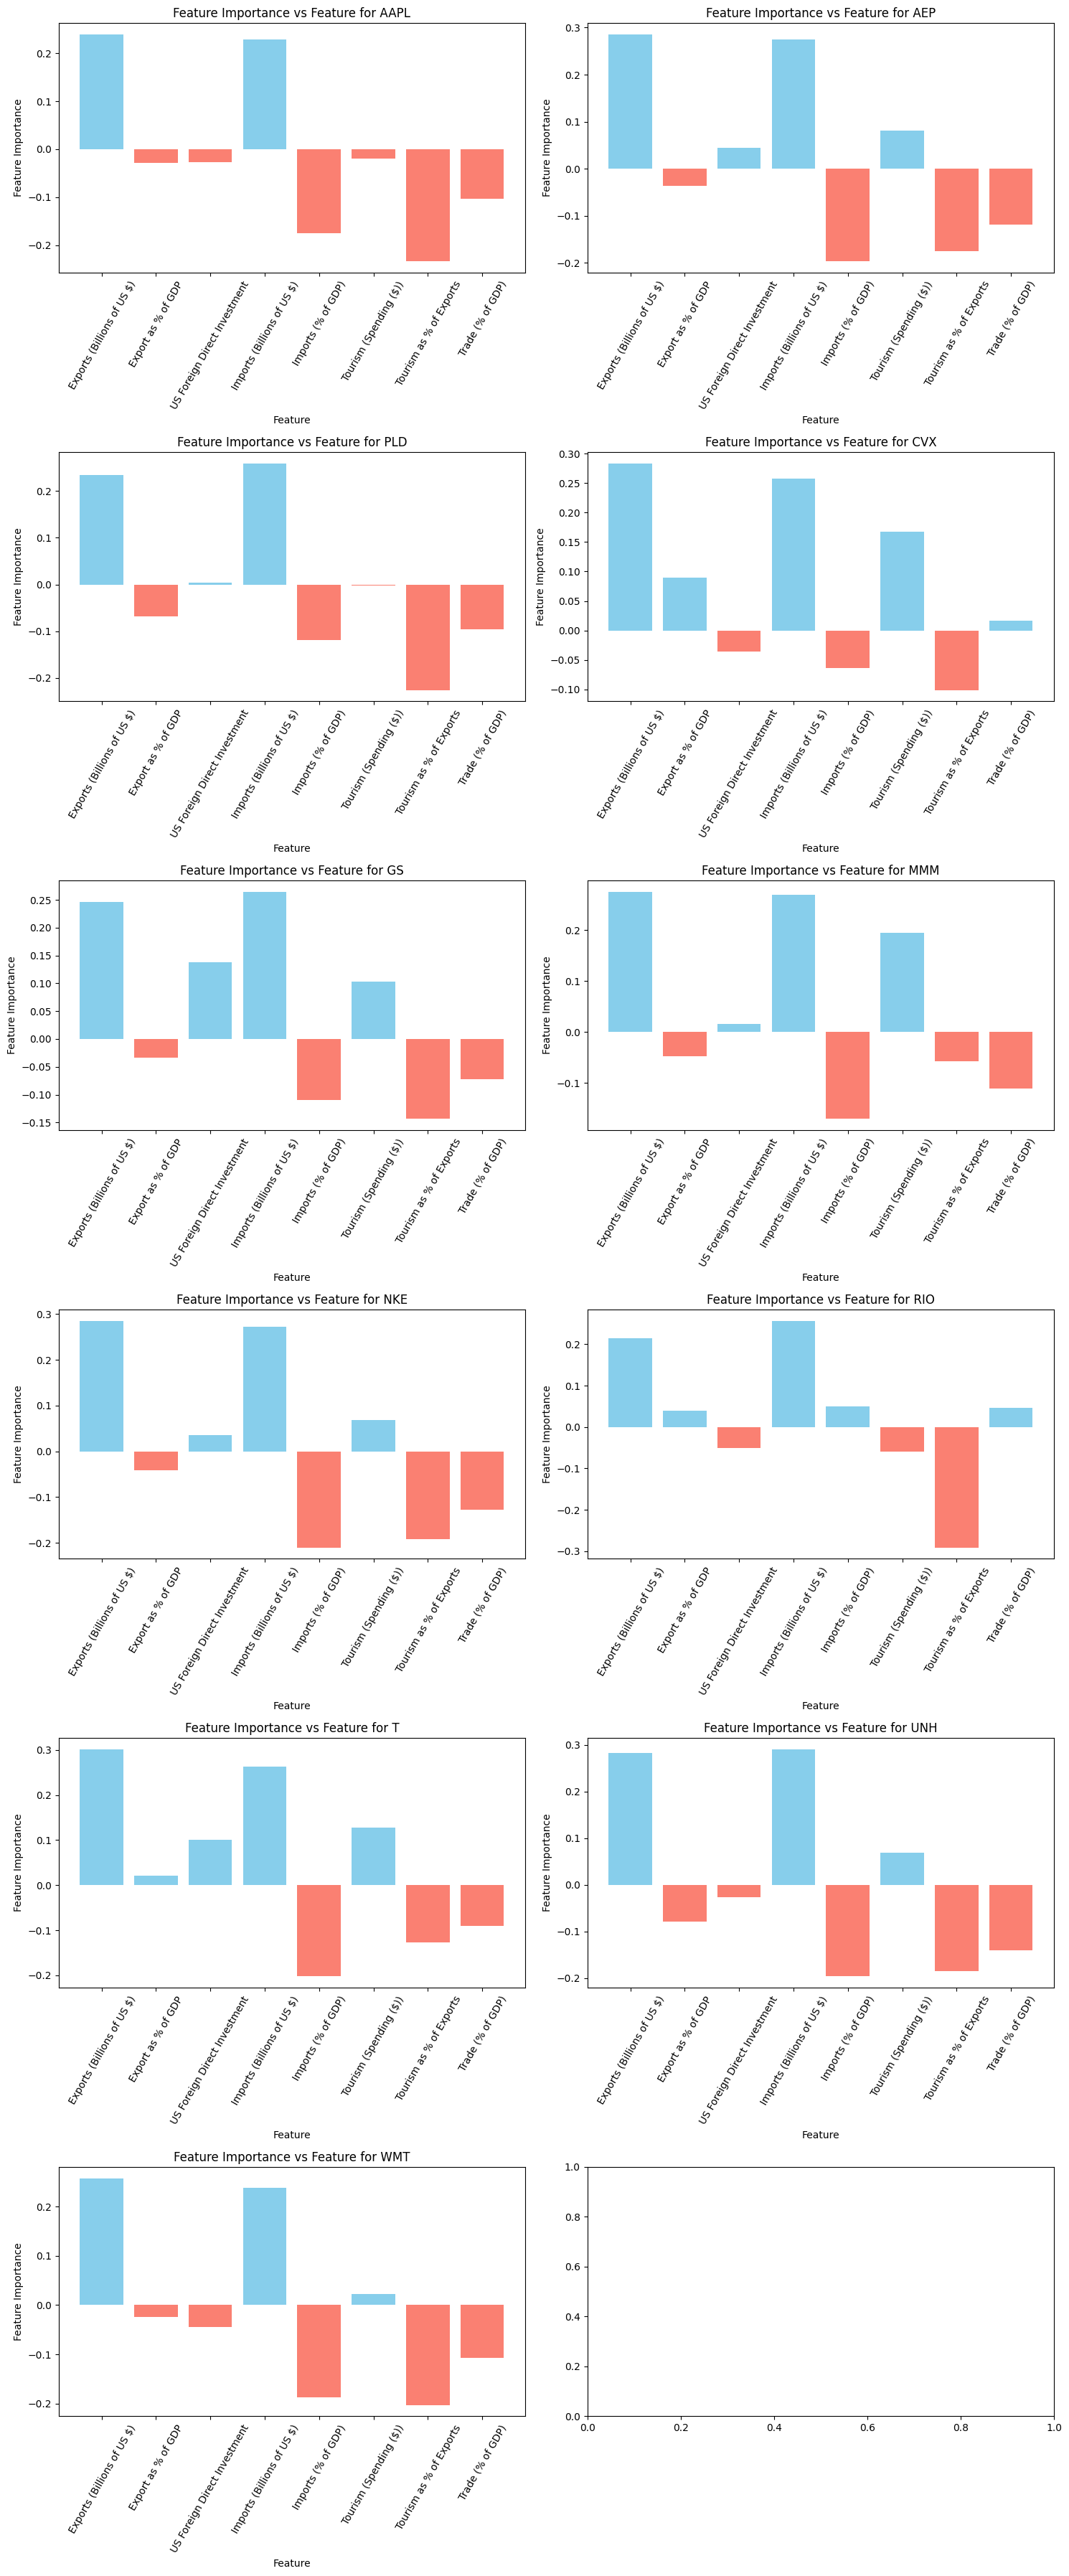

In [7]:
# Ploting the feature importance for all ticker

scaler = MinMaxScaler(feature_range=(0, 1))
feature_importance_dfs = {}
tickers = yearly_diff_df.columns[1:]  # Exclude the 'Year' column
num_plots = len(tickers)
num_rows = (num_plots + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6 * num_rows))

for i, ticker in enumerate(tickers):
    ax = axes[i // 2, i % 2]  # Select subplot
    X = final_df.drop(columns=['Year'])  # Assuming Year is not a feature
    y = yearly_diff_df[[ticker]]  # Select the column corresponding to the current ticker
    
    # Fit and transform features
    X_scaled = scaler.fit_transform(X)
    original_signs = np.sign(X.values)
    
    for i in range(X.shape[0]):  # Iterate through rows
        for j in range(X.shape[1]):  # Iterate through columns
            if original_signs[i, j] == -1:  # Check if original value was negative
                X_scaled[i, j] *= -1  # Apply negative sign to corresponding scaled feature

    y_scaled = scaler.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=86)
    
    # Train a Ridge regression model with regularization
    model = Ridge(alpha=1)  
    model.fit(X_train, y_train)
    
    # Retrieve feature importance
    feature_importance = model.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    })

    feature_importance_dfs[ticker] = feature_importance_df
    
    # Plot feature importance vs feature
    ax.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], 
           color=['skyblue' if imp >= 0 else 'salmon' for imp in feature_importance_df['Importance']])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature Importance')
    ax.set_title(f'Feature Importance vs Feature for {ticker}')
    ax.tick_params(axis='x', rotation=60)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
# Displaying feature importance

feature_importance_df = pd.DataFrame(columns=feature_importance_dfs[tickers[0]]['Feature'])
feature_importance_df.index.name = 'Ticker'

for ticker, df in feature_importance_dfs.items():
    feature_importance_df.loc[ticker] = df.set_index('Feature')['Importance']

feature_importance_df.head()  # this is features vs ticker dataframe

Feature,Exports (Billions of US $),Export as % of GDP,US Foreign Direct Investment,Imports (Billions of US $),Imports (% of GDP),Tourism (Spending ($)),Tourism as % of Exports,Trade (% of GDP)
Ticker,,,,,,,,
AAPL,0.238962,-0.028414,-0.026971,0.228150,-0.174582,-0.019913,-0.233330,-0.102771
AEP,0.285254,-0.036379,0.043895,0.274489,-0.196446,0.080958,-0.174243,-0.118015
PLD,0.234604,-0.067688,0.004464,0.259717,-0.119602,-0.002879,-0.226165,-0.096378
CVX,0.283673,0.089662,-0.036148,0.257150,-0.064362,0.168108,-0.101060,0.016045
GS,0.245738,-0.033075,0.137420,0.264103,-0.109119,0.103715,-0.143210,-0.072485


In [9]:
# Making Year vs features dataframe
factors_df = final_df.copy()
factors_df.reset_index(drop=True, inplace=True)
factors_df = factors_df.transpose()
factors_df.columns = factors_df.iloc[0]  # Set the first row as column names
factors_df = factors_df[1:]  # Exclude the first row (previously used as column names)
#factors_df.head()

In [10]:
# scaling down the features as the model is trained on scaled downed feature
factors_df_transposed = factors_df.transpose()
scaler = MinMaxScaler(feature_range=(0,1))
factors_df_scaled = pd.DataFrame(scaler.fit_transform(factors_df_transposed), columns=factors_df_transposed.columns, index=factors_df_transposed.index)
factors_df_scaled.head()    # this is features vs Year dataframe

,Exports (Billions of US $),Export as % of GDP,US Foreign Direct Investment,Imports (Billions of US $),Imports (% of GDP),Tourism (Spending ($)),Tourism as % of Exports,Trade (% of GDP)
Year,,,,,,,,
2000.0,0.063703,0.359590,0.594612,0.042617,0.292799,0.216195,1.000000,0.329192
2001.0,0.018717,0.144891,0.153457,0.000000,0.025356,0.134676,0.923211,0.079569
2002.0,0.000000,0.020767,0.000000,0.019776,0.000000,0.083725,0.851048,0.000000
2003.0,0.024139,0.000000,0.015113,0.088887,0.101868,0.067240,0.757460,0.039843
2004.0,0.115798,0.128703,0.256222,0.235554,0.388229,0.145805,0.751267,0.252650


In [11]:
factors_df_scaled = factors_df_scaled.transpose() # Year vs features dataframe

In [12]:
# Matrix multiplication
predicted_data = feature_importance_df.dot(factors_df_scaled)
predicted_data =predicted_data.transpose()
predicted_data.head()   # to get ticker vs year dataframe

Ticker,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000.0,-0.323893,-0.210221,-0.289206,-0.038502,-0.079871,-0.080466,-0.243499,-0.265060,-0.090135,-0.287699,-0.296035
2001.0,-0.234482,-0.157527,-0.224618,-0.058261,-0.105884,-0.039371,-0.177767,-0.269617,-0.088255,-0.188273,-0.202777
2002.0,-0.196320,-0.136838,-0.188988,-0.064985,-0.108659,-0.028331,-0.152329,-0.246655,-0.091926,-0.148014,-0.166415
2003.0,-0.174316,-0.119305,-0.158712,-0.042004,-0.084022,-0.021414,-0.134979,-0.190180,-0.079768,-0.129212,-0.148564
2004.0,-0.201094,-0.120928,-0.160336,0.023354,-0.031523,-0.015664,-0.146358,-0.118659,-0.052605,-0.156590,-0.176887


In [13]:
# actual data
yearly_diff_df.set_index("Year", inplace=True)
yearly_diff_df.head()

,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.671327,13.627711,9.263934,17.101933,73.437899,19.113612,4.007996,5.168020,6.920251,8.707182,11.974099
2001,0.314130,16.992678,10.833453,18.853714,66.541994,20.714679,4.628159,4.959992,6.741348,12.399304,11.009747
2002,0.298804,12.752304,12.763808,17.318587,56.857435,23.076986,5.022417,5.375450,4.684613,16.987724,11.791562
2003,0.285198,10.935412,14.655833,17.112951,59.783085,29.706298,5.437087,6.980594,4.071781,19.615665,11.731793
2004,0.685972,14.781010,18.079357,23.382475,72.618480,34.162423,7.827562,8.086415,4.549953,28.927557,12.472000


In [14]:
# Scaling down the yearly_diff_df(actual scaled down data)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(yearly_diff_df)
yearly_diff_scaled = pd.DataFrame(scaled_data, columns=yearly_diff_df.columns, index = yearly_diff_df.index)
yearly_diff_scaled.head()


,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.004119,0.043116,0.000000,0.000000,0.112261,0.000000,0.000000,0.005826,0.210252,0.000000,0.040289
2001,0.000309,0.097006,0.022616,0.022800,0.065571,0.013458,0.006444,0.000000,0.197047,0.014476,0.007478
2002,0.000145,0.029097,0.050432,0.002820,0.000000,0.033314,0.010541,0.011635,0.045235,0.032466,0.034078
2003,0.000000,0.000000,0.077696,0.000143,0.019809,0.089036,0.014849,0.056588,0.000000,0.042770,0.032045
2004,0.004275,0.061586,0.127028,0.081745,0.106713,0.126491,0.039689,0.087556,0.035295,0.079279,0.057229


In [15]:
# Writing the inverse function for actual to scale up the actual scaled down data
actual_data = scaler.inverse_transform(yearly_diff_scaled)
actual_df = pd.DataFrame(actual_data, columns=yearly_diff_scaled.columns, index=yearly_diff_scaled.index)
actual_df.head()

,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.671327,13.627711,9.263934,17.101933,73.437899,19.113612,4.007996,5.168020,6.920251,8.707182,11.974099
2001,0.314130,16.992678,10.833453,18.853714,66.541994,20.714679,4.628159,4.959992,6.741348,12.399304,11.009747
2002,0.298804,12.752304,12.763808,17.318587,56.857435,23.076986,5.022417,5.375450,4.684613,16.987724,11.791562
2003,0.285198,10.935412,14.655833,17.112951,59.783085,29.706298,5.437087,6.980594,4.071781,19.615665,11.731793
2004,0.685972,14.781010,18.079357,23.382475,72.618480,34.162423,7.827562,8.086415,4.549953,28.927557,12.472000


In [16]:
# Using the inverse function on the predicted data to scale up
original_predicted_data = scaler.inverse_transform(predicted_data)
original_predicted_df = pd.DataFrame(original_predicted_data, columns=predicted_data.columns, index=predicted_data.index)
original_predicted_df.head()

Ticker,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000.0,-30.075987,-2.191321,-10.806182,14.143777,45.060790,9.540497,-19.425962,-4.504638,2.850641,-64.671238,2.089127
2001.0,-21.694751,1.099011,-6.323978,12.625660,41.218815,14.429590,-13.100012,-4.667366,2.876115,-39.312383,4.830098
2002.0,-18.117567,2.390894,-3.851325,12.109099,40.808994,15.743036,-10.651911,-3.847437,2.826378,-29.044055,5.898819
2003.0,-16.054891,3.485734,-1.750270,13.874726,44.447800,16.565934,-8.982127,-1.830856,2.991095,-24.248666,6.423486
2004.0,-18.564991,3.384372,-1.862992,18.896225,52.201570,17.250088,-10.077279,0.722980,3.359099,-31.231336,5.591047


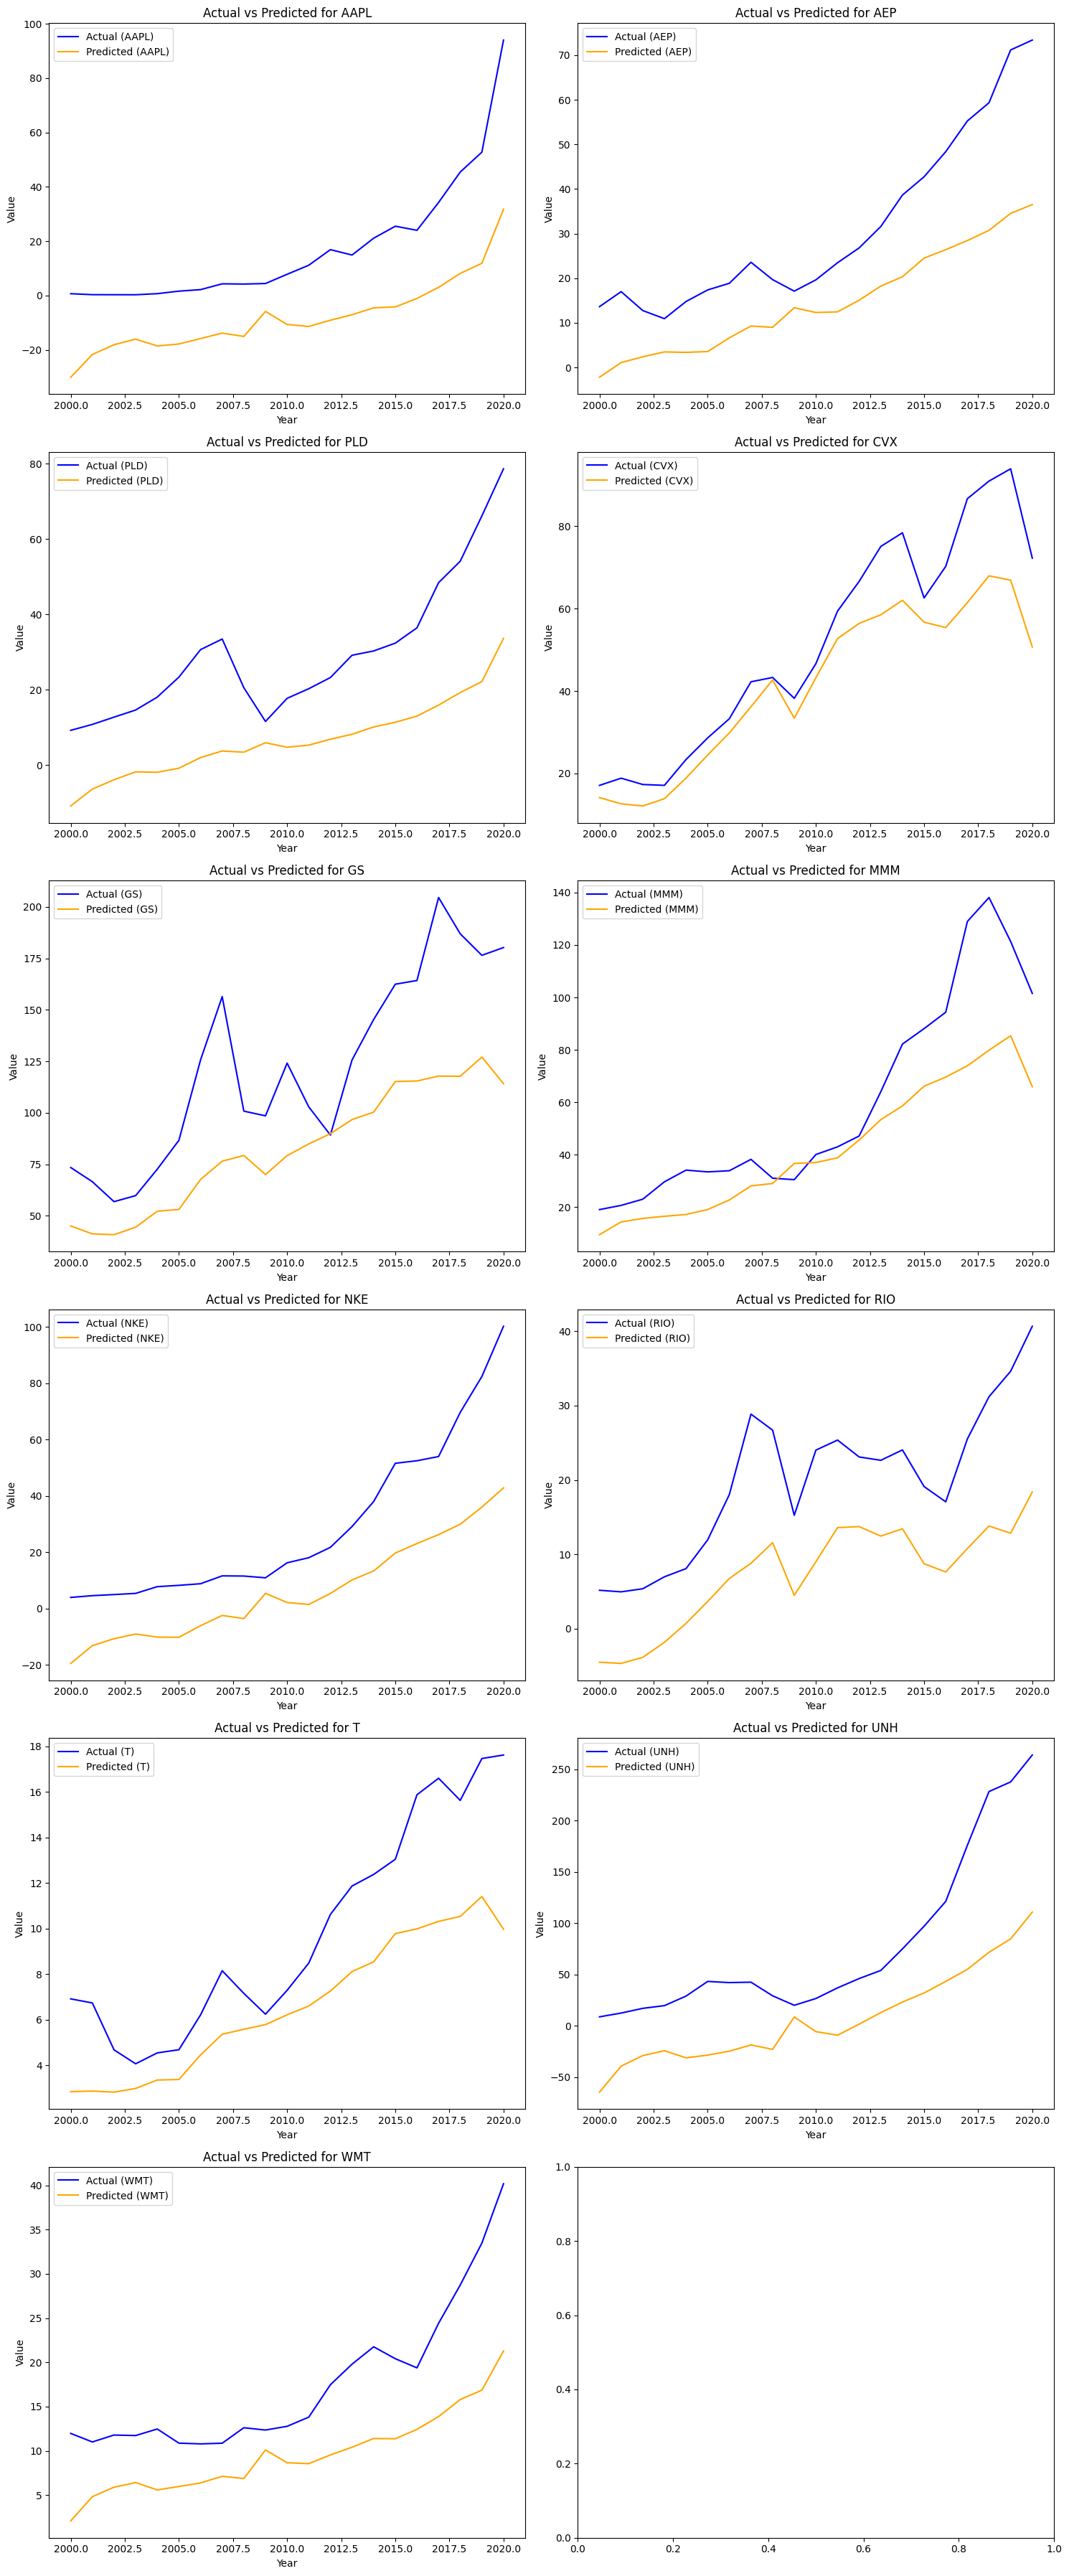

In [17]:
# Plotting actual vs predicted

num_tickers = len(actual_df.columns)
num_rows = (num_tickers + 1) // 2  
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
axes = axes.flatten()


for i, (ticker, ax) in enumerate(zip(actual_df.columns, axes)):
    ax.plot(actual_df.index, actual_df[ticker], label=f'Actual ({ticker})', color='blue')
    ax.plot(original_predicted_df.index, original_predicted_df[ticker], label=f'Predicted ({ticker})', color='orange')
    
    ax.set_title(f'Actual vs Predicted for {ticker}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()
